In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.spatial.distance
import scipy

import csv

In [2]:
with open("dataset.csv") as file_name:
    data = np.loadtxt(file_name, delimiter=",")

print(data)
#pred_dist,pred_heading,delta_dist,delta_heading

[[ 0.00000000e+00  1.27948345e+00  4.74337718e-01 -8.74834541e-02
   1.06622819e-02]
 [ 1.00000000e+00  1.26579119e+00  3.80654890e-01 -3.27911898e-02
   3.53451097e-02]
 [ 2.00000000e+00  1.25431272e+00  2.85646377e-01  9.68728035e-03
   2.35362325e-03]
 ...
 [ 6.44000000e+03  1.31525727e+00  2.68916576e-01  2.57427338e-02
  -2.91657649e-03]
 [ 6.44100000e+03  1.30061363e+00  2.71174719e-01  1.53863737e-02
  -5.17471867e-03]
 [ 6.44200000e+03  1.28849921e+00  1.90945566e-01  2.75007863e-02
   2.60544337e-02]]


In [3]:
def RBF_nd(X1, X2, l, var):
    '''
        l = lengthscale
        var = variance (sigma^2)
        
        scipy.spatial.distance.cdist(XA, XB, metric='euclidean', *, out=None, **kwargs)
        Compute distance between each pair of the two collections of inputs.
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
        
        Kxx = | k(x1,x1)   k(x1,x2)   ....   k(x1,xn) |
              |                                       |
              | k(xn,x1)   k(xn,x2)   ....   k(xn,xn) |
    '''
    d = scipy.spatial.distance.cdist(X1, X2, 'cityblock')
    K = var * np.exp(-(d**2)/(2*(l**2)))
    return K
    
def GP(x_in, y_out, x_test, l, var, noise, prior_mean):
    #prior_mean = 0
    #noise = 1e-5
    
    Kxx = RBF_nd(x_in, x_in, l, var)

    L = np.linalg.cholesky(Kxx + noise*np.eye(x_in.shape[0])) # add noise

    alpha = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, y_out, lower=True)) # solve(a, b) --> ax = b --> x = a\b = a^-1b

    Kxxt = RBF_nd(x_in, x_test, l, var)

    Kxtxt = RBF_nd(x_test, x_test, l, var)

    mu_post = np.matmul(Kxxt.T, alpha)

    v = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, Kxxt, lower=True))
    sigma_post = Kxtxt - np.matmul(Kxxt.T, v)
    
    return mu_post, sigma_post
 
def log_like(x_in, y_out, x_test, l, var, noise):
    Kxx = RBF_nd(x_in, x_in, l, var)
    
    L = np.linalg.cholesky(Kxx + noise*np.eye(x_in.shape[0])) # add noise

    alpha = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, y_out, lower=True)) # solve(a, b) --> ax = b --> x = a\b = a^-1b

    #MLL = (-.5*train_out.T*np.inv(Kxx)*train_out) - (.5*np.log(Kxx)) - (n/2)*np.log(2*np.pi)
    
    #np.sum(np.log(np.abs(K_chol))) + np.sum(scipy.linalg.solve_triangular((y_out), K_chol)**2) - 

    temp = 0
    n = len(x_in) #num training points
    y_out = y_out.reshape(len(y_out), 1)
    alpha = alpha.reshape(len(alpha), 1)
    for i in range(len(L)):
        temp+=np.log(L[i][i])
    MLL = -.5*y_out.T*alpha - temp - (n/2)*np.log(2*np.pi)
    MLL = -.5*y_out.T@alpha - temp - (n/2)*np.log(2*np.pi)
    #print(y_out.shape)
    #print(alpha.shape)
    #print((y_out.T*alpha).shape)
    return float(MLL)
    
def sum_sq_err(y_pred, y_true):
    total = 0
    for i in range(len(y_pred)):
        total+=((y_pred[i] - y_true[i])**2)
    return total

def MSE(mean_out, y_true):
    total = 0
    for i in range(len(mean_out)):
        total+=((mean_out[i][0] - y_true[i])**2)
    return total

def neg_log_prob(mean_out, y_true, post_var):
    noise = 1e-5*np.eye(post_var.shape[0])
    pred_var = post_var + noise
    #print((2*np.pi*pred_var))
    return .5*np.log(2*np.pi*(np.abs(pred_var))) + ((y_true-mean_out)**2)/(2*pred_var)

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, DotProduct, RBF
import matplotlib.pyplot as plt
import numpy as np

# Random seeds
np.random.seed(seed=0)  # Set seed for NumPy
random_state = 0


# Create kernel and define GPR
kernel = RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=random_state)

In [5]:
data = data.T

In [6]:
x = data[1:3]
x.shape

(2, 6443)

In [7]:
y1 = data[3]
y2 = data[4]

In [8]:
x = x.T

In [9]:
print('x = [pred_dist, pred_heading] \ny1 = delta_dist \ny2 = delta_heading')
#pred_dist,pred_heading,delta_dist,delta_heading

x = [pred_dist, pred_heading] 
y1 = delta_dist 
y2 = delta_heading


In [10]:
x_train = []
y1_train = []
y2_train = []
x_test = []
y1_test = []
y2_test = []

ind = np.random.randint(0, len(x), 1000)

for i in range(len(x)):
    if i in ind:
        x_test.append(x[i])
        y1_test.append(y1[i])
        y2_test.append(y2[i])
    else:
        x_train.append(x[i])
        y1_train.append(y1[i])
        y2_train.append(y2[i])
        
x_test = np.array(x_test)
y1_test = np.array(y1_test)
y2_test = np.array(y2_test)

x_train = np.array(x_train)
y1_train = np.array(y1_train)
y2_train = np.array(y2_train)

In [11]:
mu1, sigma1 = GP(x_train[0:100], y1_train[0:100], x_test[0:100], 1, .0001, 0.01, 0)
mu2, sigma2 = GP(x_train[0:100], y2_train[0:100], x_test[0:100], 1, .0001, 0.01, 0)

In [12]:
# Fit GPR model
gpr.fit(x_train[0:100], y1_train[0:100])
 
# Predict mean
y_hat1, y_sigma1 = gpr.predict(x_test[0:100], return_std=True)

#print('params: ', gpr.get_params)
print('log like: ', gpr.log_marginal_likelihood_value_)
print('all: ', gpr.kernel_)

gpr.fit(x_train[0:100], y2_train[0:100])

y_hat2, y_sigma2 = gpr.predict(x_test[0:100], return_std=True)
print('log like: ', gpr.log_marginal_likelihood_value_)
print('all: ', gpr.kernel_)

log like:  217.89128850531876
all:  RBF(length_scale=1.23) + WhiteKernel(noise_level=0.000186)
log like:  268.71088452951363
all:  RBF(length_scale=341) + WhiteKernel(noise_level=0.000236)


In [13]:
mu1_opt, sigma1_opt = GP(x_train[0:100], y1_train[0:100], x_test[0:100], 1.2, .00017, 0.01, 0)
mu2_opt, sigma2_opt = GP(x_train[0:100], y2_train[0:100], x_test[0:100], 282, .000247, 0.01, 0)

In [14]:
log_like1 = log_like(x_train[0:100], y1_train[0:100], x_test[0:100], 1, .0001, 0.01)
log_like2 = log_like(x_train[0:100], y2_train[0:100], x_test[0:100], 1, .0001, 0.01)
log_like1_opt = log_like(x_train[0:100], y1_train[0:100], x_test[0:100], 1.2, .00017, 0.01)
log_like2_opt = log_like(x_train[0:100], y2_train[0:100], x_test[0:100], 282, .000247, 0.01)

In [15]:
print(mu1[0])
print(mu1_opt[0])
print(y_hat1[0])

print(mu2[0])
print(mu2_opt[0])
print(y_hat2[0])

print(log_like1)
print(log_like1_opt)

print(log_like2)
print(log_like2_opt)

0.00321518049792624
0.004235115372789251
-0.08523353295296943
0.0028349592422641026
0.005570751410669583
0.012083873674612278
56.84406499476431
59.48284401581235
136.48355929527304
136.40420062872977


In [16]:
log_like(x_train[0:100], y1_train[0:100], x_test[0:100], 1.5, .001, 0.01)

73.53709250073273

In [17]:
log_like(x_train[0:100], y2_train[0:100], x_test[0:100], 200, .00001, 0.001)

239.11513021284821

In [18]:
mu_1, sigma_1 = GP(x_train[0:100], y1_train[0:100], x_test[0:100], 1.5, .001, 0.01, 0)
mu_2, sigma_2 = GP(x_train[0:100], y2_train[0:100], x_test[0:100], 200, .0001, 0.01, 0)

y1_predict = np.random.multivariate_normal(mu_1, sigma_1)
y2_predict = np.random.multivariate_normal(mu_2, sigma_2)

<ipython-input-18-117fc4eb1419>:4: RuntimeWarning: covariance is not positive-semidefinite.
  y1_predict = np.random.multivariate_normal(mu_1, sigma_1)
<ipython-input-18-117fc4eb1419>:5: RuntimeWarning: covariance is not positive-semidefinite.
  y2_predict = np.random.multivariate_normal(mu_2, sigma_2)


In [19]:
#pred_dist,pred_heading,delta_dist,delta_heading
pred_dist = data[1][0:100]
pred_heading = data[2][0:100]
delta_dist = data[3][0:100]
delta_heading = data[4][0:100]

In [20]:
#pred_dist,pred_heading,delta_dist,delta_heading
pred_dist = x_train.T[0][0:100]
pred_heading = x_train.T[1][0:100]
delta_dist = y1_test[0:100]
delta_heading = y2_test[0:100]

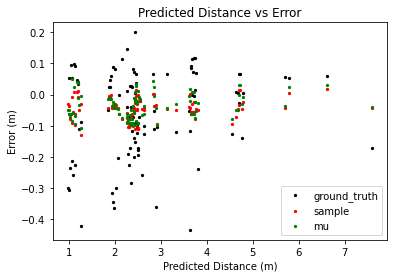

In [21]:
plt.scatter(pred_dist, delta_dist, s=5, label="ground_truth", color = 'black')
plt.scatter(pred_dist, y1_predict, s=5, label="sample", color = 'red')
plt.scatter(pred_dist, mu_1, s=5, label="mu", color = 'green')
plt.title("Predicted Distance vs Error")
plt.ylabel("Error (m)")
plt.xlabel("Predicted Distance (m)")
plt.legend()
#plt.savefig("output/part_3_distance.png")
#plt.clf()
plt.show()

Text(0, 0.5, 'Predicted Error (m)')

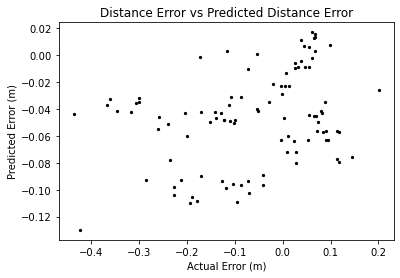

In [22]:
plt.scatter(delta_dist, y1_predict, s=5, color = 'black')

#min_dist = max(dataset[:,2].min(), Y_pred[:,0].min())
#max_dist = min(dataset[:,2].max(), Y_pred[:,0].max())
#plt.plot([min_dist, max_dist], [min_dist, max_dist], c="black")

plt.title("Distance Error vs Predicted Distance Error")
plt.xlabel("Actual Error (m)")
plt.ylabel("Predicted Error (m)")
#plt.savefig("output/part_3_error_distance.png")
#plt.clf()
plt.show()

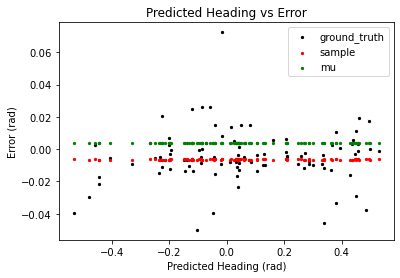

In [23]:
plt.scatter(pred_heading, delta_heading, s=5, label="ground_truth", color = 'black')
plt.scatter(pred_heading, y2_predict, s=5, label="sample", color = 'red')
plt.scatter(pred_heading, mu_2, s=5, label="mu", color = 'green')
plt.title("Predicted Heading vs Error")
plt.ylabel("Error (rad)")
plt.xlabel("Predicted Heading (rad)")
plt.legend()
#plt.savefig("output/part_3_heading.png")
#plt.clf()
plt.show()

Text(0, 0.5, 'Predicted Error (rad)')

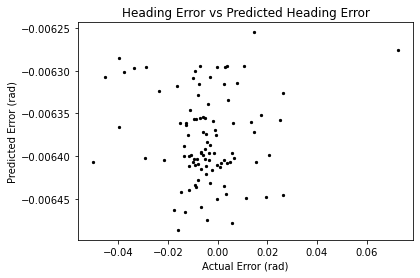

In [24]:
plt.scatter(delta_heading, y2_predict, s=5, color = 'black')

#min_dist = max(dataset[:,3].min(), Y_pred[:,1].min())
#max_dist = min(dataset[:,3].max(), Y_pred[:,1].max())
#plt.plot([min_dist, max_dist], [min_dist, max_dist], c="black")

plt.title("Heading Error vs Predicted Heading Error")
plt.xlabel("Actual Error (rad)")
plt.ylabel("Predicted Error (rad)")
#plt.savefig("output/part_3_error_heading.png")
#plt.clf()
plt.show()

In [25]:
'''
# Fit GPR model
gpr.fit(x_train[0:5000], y1_train[0:5000])
 
# Predict mean
y_hat1, y_sigma1 = gpr.predict(x_test[0:500], return_std=True)

#print('params: ', gpr.get_params)
print('log like: ', gpr.log_marginal_likelihood_value_)
print('all: ', gpr.kernel_)

gpr.fit(x_train[0:5000], y2_train[0:5000])

y_hat2, y_sigma2 = gpr.predict(x_test[0:500], return_std=True)
print('log like: ', gpr.log_marginal_likelihood_value_)
print('all: ', gpr.kernel_)
'''

log like:  11741.835267496426
all:  RBF(length_scale=1.03) + WhiteKernel(noise_level=0.0005)
log like:  14526.588989329783
all:  RBF(length_scale=2.39) + WhiteKernel(noise_level=0.00017)


In [77]:
print('Hyperparameters from sklearn gpr.fit.  Commented out due to long runtime.')
print('log like:  11741.835267496426')
print('RBF(length_scale=1.03) + WhiteKernel(noise_level=0.0005)')
print('log like:  14526.588989329783')
print('RBF(length_scale=2.39) + WhiteKernel(noise_level=0.00017)')

Hyperparameters from sklearn gpr.fit.  Commented out due to long runtime.
log like:  11741.835267496426
RBF(length_scale=1.03) + WhiteKernel(noise_level=0.0005)
log like:  14526.588989329783
RBF(length_scale=2.39) + WhiteKernel(noise_level=0.00017)


In [26]:
mu1_opt1, sigma1_opt1 = GP(x_train[0:5000], y1_train[0:5000], x_test[0:500], 1, .00025, 0.01, 0)
mu2_opt2, sigma2_opt2 = GP(x_train[0:5000], y2_train[0:5000], x_test[0:500], 10, .0001, 0.01, 0)

In [27]:
log_like1_opt1 = log_like(x_train[0:5000], y1_train[0:5000], x_test[0:500], 1, .00025, 0.01)
log_like2_opt2 = log_like(x_train[0:5000], y2_train[0:5000], x_test[0:500], 10, .0001, 0.01)

In [28]:
log_like(x_train[0:5000], y1_train[0:5000], x_test[0:500], 1, .0001, 0.01)

4017.771139855936

In [29]:
log_like(x_train[0:5000], y1_train[0:5000], x_test[0:500], 1, .0002, 0.01)

4647.781611543108

In [30]:
log_like(x_train[0:5000], y1_train[0:5000], x_test[0:500], 1, .00025, 0.01)

4829.206359682476

In [31]:
log_like(x_train[0:5000], y2_train[0:5000], x_test[0:500], 1, .0001, 0.01)

6864.405217191489

In [32]:
log_like(x_train[0:5000], y2_train[0:5000], x_test[0:500], 2, .0001, 0.01)

6866.785642763719

In [33]:
log_like(x_train[0:5000], y2_train[0:5000], x_test[0:500], 10, .0001, 0.01)

6867.709728892273

In [34]:
y1_predict1 = np.random.multivariate_normal(mu1_opt1, sigma1_opt1)
y2_predict2 = np.random.multivariate_normal(mu2_opt2, sigma2_opt2)

<ipython-input-34-8892454757e1>:1: RuntimeWarning: covariance is not positive-semidefinite.
  y1_predict1 = np.random.multivariate_normal(mu1_opt1, sigma1_opt1)
<ipython-input-34-8892454757e1>:2: RuntimeWarning: covariance is not positive-semidefinite.
  y2_predict2 = np.random.multivariate_normal(mu2_opt2, sigma2_opt2)


In [35]:
print(y1_predict[0:5])
print(y1_predict1[0:5])
print(y_hat1[0:5])
print(y1_test[0:5])

print('\n')
print(y1_predict[-5:-1])
print(y1_predict1[-5:-1])
print(y_hat1[-5:-1])
print(y1_test[-5:-1])

[-0.03115097 -0.12991249 -0.09553632 -0.03234401 -0.04866009]
[-0.04428323 -0.24301902 -0.11137109 -0.21906373 -0.15449973]
[-0.06195894 -0.46927296 -0.08195541 -0.37457643 -0.09561949]
[-0.08748345 -0.42231609 -0.10287529 -0.36101065 -0.10934721]


[-0.00847079 -0.00922864 -0.00566524 -0.04167211]
[-0.05607652  0.0406553   0.07110503  0.05247544]
[0.011938   0.06159107 0.02850546 0.01529347]
[-0.01973102 -0.00965242 -0.00810514 -0.00450304]


In [36]:
print(mu1_opt1[0:5])
print('\n')
print(mu2_opt2[0:5])
print('\n')
print(mu1_opt1[-5:-1])
print('\n')
print(mu2_opt2[-5:-1])

[-0.05076721 -0.24749236 -0.11580024 -0.22501632 -0.1604156 ]


[-0.00965811 -0.00757396 -0.00720782 -0.00736955 -0.00881669]


[-0.06366202  0.04080263  0.05883358  0.04405154]


[-0.00899275 -0.00903031 -0.00927957 -0.0093494 ]


In [37]:
#pred_dist,pred_heading,delta_dist,delta_heading
pred_dist = x_train.T[0]
pred_heading = x_train.T[1]
delta_dist = y1_test
delta_heading = y2_test

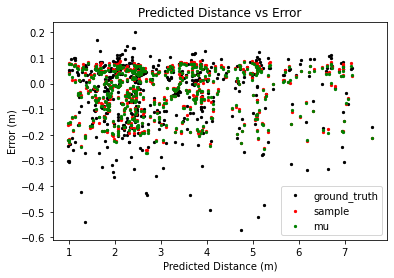

In [38]:
plt.scatter(pred_dist[0:500], delta_dist[0:500], s=5, label="ground_truth", color = 'black')
plt.scatter(pred_dist[0:500], y1_predict1, s=5, label="sample", color = 'red')
plt.scatter(pred_dist[0:500], mu1_opt1, s=5, label="mu", color = 'green')
plt.title("Predicted Distance vs Error")
plt.ylabel("Error (m)")
plt.xlabel("Predicted Distance (m)")
plt.legend()
plt.show()

Text(0, 0.5, 'Predicted Error (m)')

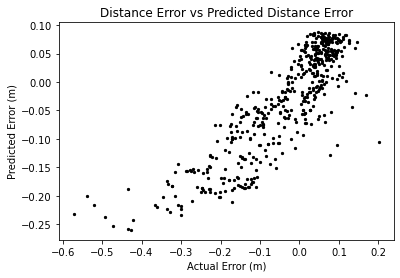

In [39]:
plt.scatter(delta_dist[0:500], y1_predict1, s=5, color = 'black')

#min_dist = max(dataset[:,2].min(), Y_pred[:,0].min())
#max_dist = min(dataset[:,2].max(), Y_pred[:,0].max())
#plt.plot([min_dist, max_dist], [min_dist, max_dist], c="black")

plt.title("Distance Error vs Predicted Distance Error")
plt.xlabel("Actual Error (m)")
plt.ylabel("Predicted Error (m)")
#plt.savefig("output/part_3_error_distance.png")
#plt.clf()
plt.show()

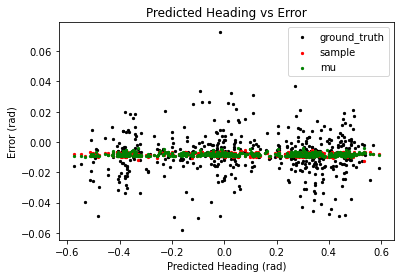

In [40]:
plt.scatter(pred_heading[0:500], delta_heading[0:500], s=5, label="ground_truth", color = 'black')
plt.scatter(pred_heading[0:500], y2_predict2, s=5, label="sample", color = 'red')
plt.scatter(pred_heading[0:500], mu2_opt2, s=5, label="mu", color = 'green')
plt.title("Predicted Heading vs Error")
plt.ylabel("Error (rad)")
plt.xlabel("Predicted Heading (rad)")
plt.legend()
#plt.savefig("output/part_3_heading.png")
#plt.clf()
plt.show()

Text(0, 0.5, 'Predicted Error (rad)')

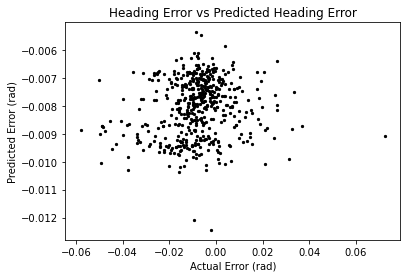

In [41]:
plt.scatter(delta_heading[0:500], y2_predict2, s=5, color = 'black')

#min_dist = max(dataset[:,3].min(), Y_pred[:,1].min())
#max_dist = min(dataset[:,3].max(), Y_pred[:,1].max())
#plt.plot([min_dist, max_dist], [min_dist, max_dist], c="black")

plt.title("Heading Error vs Predicted Heading Error")
plt.xlabel("Actual Error (rad)")
plt.ylabel("Predicted Error (rad)")
#plt.savefig("output/part_3_error_heading.png")
#plt.clf()
plt.show()

In [42]:
#igor used MSE for metric, so do sum_sq_err(y_pred, y_true) then divide by num predictions

In [50]:
mse1 = sum_sq_err(y1_predict1, delta_dist[0:500])/len(y1_predict1)
mse2 = sum_sq_err(y2_predict2, delta_heading[0:500])/len(y2_predict2)
print(mse1)
print(mse2)

0.004580227377544908
0.00018915514134879935


In [51]:
#pred_dist,pred_heading,delta_dist,delta_heading
data.shape

(5, 6443)

In [52]:
print(np.sqrt(mse1))
print(np.sqrt(mse2))

0.06767737714735189
0.013753368363742729


In [53]:
y2_predict2.shape

(500,)

In [54]:
x_test.shape

(928, 2)

In [55]:
'''
# Fit GPR model
gpr.fit(x_train, y1_train)
 
# Predict mean
delta_dist, sigma_d = gpr.predict(x_test, return_std=True)

#print('params: ', gpr.get_params)
print('log like: ', gpr.log_marginal_likelihood_value_)
print('all: ', gpr.kernel_)

gpr.fit(x_train, y2_train)

delta_head, sigma_h = gpr.predict(x_test, return_std=True)
print('log like: ', gpr.log_marginal_likelihood_value_)
print('all: ', gpr.kernel_)
'''

log like:  12965.13637214351
all:  RBF(length_scale=0.977) + WhiteKernel(noise_level=0.000499)
log like:  16019.586068726689
all:  RBF(length_scale=2.28) + WhiteKernel(noise_level=0.00017)


In [76]:
print('Hyperparameters from sklearn gpr.fit.  Commented out due to long runtime.')
print('log like:  12965.13637214351')
print('RBF(length_scale=0.977) + WhiteKernel(noise_level=0.000499)')
print('log like:  16019.586068726689')
print('RBF(length_scale=2.28) + WhiteKernel(noise_level=0.00017)')

Hyperparameters from sklearn gpr.fit.  Commented out due to long runtime.
log like:  12965.13637214351
RBF(length_scale=0.977) + WhiteKernel(noise_level=0.000499)
log like:  16019.586068726689
RBF(length_scale=2.28) + WhiteKernel(noise_level=0.00017)


In [57]:
mu_d, sigmaD = GP(x_train, y1_train, x_test, 1, .0005, 0.05, 0)
mu_h, sigmaH = GP(x_train, y2_train, x_test, 2.25, .0002, 0.01, 0)

In [58]:
log_liked = log_like(x_train, y1_train, x_test, 1, .0005, 0.05)
log_likeh = log_like(x_train, y1_train, x_test, 2.25, .0002, 0.01)

In [59]:
y_p_d = np.random.multivariate_normal(mu_d, sigmaD)
y_p_h = np.random.multivariate_normal(mu_h, sigmaH)

<ipython-input-59-def186aa475f>:1: RuntimeWarning: covariance is not positive-semidefinite.
  y_p_d = np.random.multivariate_normal(mu_d, sigmaD)
<ipython-input-59-def186aa475f>:2: RuntimeWarning: covariance is not positive-semidefinite.
  y_p_h = np.random.multivariate_normal(mu_h, sigmaH)


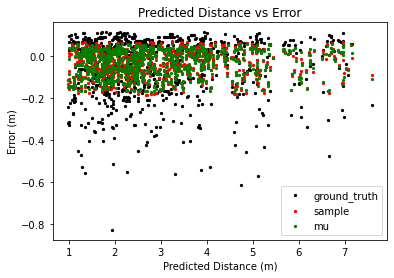

In [67]:
plt.scatter(pred_dist[0:928], delta_dist, s=5, label="ground_truth", color = 'black')
plt.scatter(pred_dist[0:928], y_p_d, s=5, label="sample", color = 'red')
plt.scatter(pred_dist[0:928], mu_d, s=5, label="mu", color = 'green')
plt.title("Predicted Distance vs Error")
plt.ylabel("Error (m)")
plt.xlabel("Predicted Distance (m)")
plt.legend()
plt.show()

Text(0, 0.5, 'Predicted Error (m)')

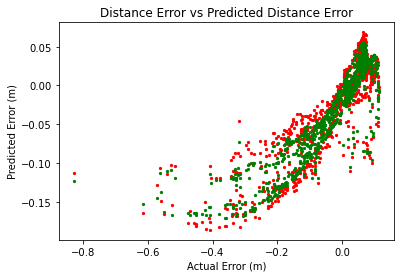

In [74]:
plt.scatter(delta_dist[0:928], y_p_d, s=5, color = 'red')
plt.scatter(delta_dist[0:928], mu_d, s=5, color = 'green')


#min_dist = max(dataset[:,2].min(), Y_pred[:,0].min())
#max_dist = min(dataset[:,2].max(), Y_pred[:,0].max())
#plt.plot([min_dist, max_dist], [min_dist, max_dist], c="black")

plt.title("Distance Error vs Predicted Distance Error")
plt.xlabel("Actual Error (m)")
plt.ylabel("Predicted Error (m)")
plt.show()

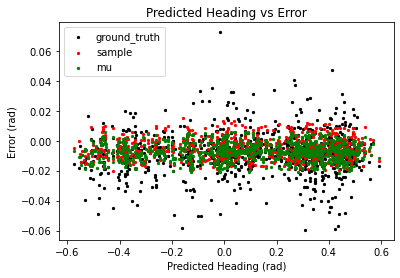

In [69]:
plt.scatter(pred_heading[0:928], delta_heading, s=5, label="ground_truth", color = 'black')
plt.scatter(pred_heading[0:928], y_p_h, s=5, label="sample", color = 'red')
plt.scatter(pred_heading[0:928], mu_h, s=5, label="mu", color = 'green')
plt.title("Predicted Heading vs Error")
plt.ylabel("Error (rad)")
plt.xlabel("Predicted Heading (rad)")
plt.legend()
plt.show()

Text(0, 0.5, 'Predicted Error (rad)')

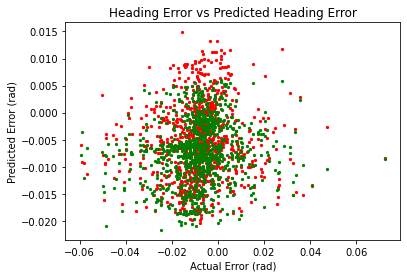

In [72]:
plt.scatter(delta_heading[0:928], y_p_h, s=5, color = 'red')
plt.scatter(delta_heading[0:928], mu_h, s=5, color = 'green')

#min_dist = max(dataset[:,3].min(), Y_pred[:,1].min())
#max_dist = min(dataset[:,3].max(), Y_pred[:,1].max())
#plt.plot([min_dist, max_dist], [min_dist, max_dist], c="black")

plt.title("Heading Error vs Predicted Heading Error")
plt.xlabel("Actual Error (rad)")
plt.ylabel("Predicted Error (rad)")
plt.show()

In [75]:
print('MSE distance: ', sum_sq_err(mu_d, delta_dist[0:928])/len(mu_d))
print('MSE heading: ', sum_sq_err(mu_h, delta_heading[0:928])/len(mu_h))
print('RMSE distance: ', np.sqrt(sum_sq_err(mu_d, delta_dist[0:928])/len(mu_d)))
print('RMSE heading: ', np.sqrt(sum_sq_err(mu_h, delta_heading[0:928])/len(mu_h)))

MSE distance:  0.00772545737244663
MSE heading:  0.00020401462154726022
RMSE distance:  0.08789458101866479
RMSE heading:  0.01428336870444995
